In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import sys
import seaborn as sns
import matplotlib.pyplot as plt

#For woring in Google Colab Directory
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/COMP 642/proj/')
path = '/content/gdrive/My Drive/COMP 642/proj/'

import prepare_edr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#K-means clustering
test_data = prepare_edr.PrepareEDR("/content/gdrive/My Drive/COMP 642/proj/well_1.csv")

#Architecture contains the scaler so we can quickly back-out the original data if we wanted to.
X_train, X_headers, scaler = test_data.getClusteringTrainingData()


In [3]:
#From prior elbow modeling, number of clusters was decided as 8. Tune hyperparameters such as n_init and max_iterations (too high and we may be over-fitting)
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

#Decided on 6 clusters due to semantic meaning of cluster centroids. 
#More clusters convoluted the classification.
n_clusters = 6

#variables to capture our optimal hyperparameters
min_inertia = float("inf")
n_init_opt = 0
max_iter_opt = 0

for i in range(10, 40, 10):
  for j in range(300, 600, 100):
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=i, max_iter=j, random_state=0)
    km.fit(X_train)
    if km.inertia_ < min_inertia:
      min_inertia = km.inertia_
      n_init_opt = i
      max_iter_opt = j

##re-train with the optimal parameters; and then view and reason about the centroids.
#output cluster values to reason about semantic meaning.
print("k selection: " + str(n_clusters))
print("Optimal n_init value: " + str(n_init_opt))
print("Optimal max_iter value: " + str(max_iter_opt))
km_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=n_init_opt, max_iter=max_iter_opt, random_state=0)
km_final.fit(X_train)
centroids = km_final.cluster_centers_
centroid_params = scaler.inverse_transform(centroids)
centroid_params_df = pd.DataFrame(data = centroid_params, columns=X_headers)
centroid_params_df

k selection: 6
Optimal n_init value: 30
Optimal max_iter value: 300


,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,On Bottom ROP,Standpipe Pressure,Convertible Torque
0,0.997532,25.236191,16.829412,271.343923,-0.019123,333.258765,190.326069,2.147459e+01,2739.883179,6.077638
1,0.999603,46.402745,19.107456,305.765625,-0.962389,744.690096,158.047707,1.330199e+02,3261.012280,8.368973
2,0.123063,0.317969,0.010000,0.099544,0.017737,4.556358,45.646147,-2.557954e-12,15.292398,0.213143
3,0.980308,71.174267,18.924808,343.425703,0.001357,135.098711,221.725825,1.516078e+01,5053.083876,10.069887
4,0.922515,3.316259,0.548255,46.131071,0.148186,11.456697,81.195825,9.531143e-03,417.264610,3.073220
5,0.999549,118.253206,32.835442,341.488702,-0.983914,1049.380633,207.824611,2.921441e+02,5961.902499,17.459994


In [4]:
#Now, get the labels and apply them to the original data. 
#Then, visualize and reason about the accuracy of the labels.

#Reason about what each category could suggest about rig operations
label_categories = ["Rotate Drill AHead - Light Parameters", 
                    "Rotate Drill Ahead", 
                    "Connection - In Slips", 
                    "Directional Drill Ahead", 
                    "Connection - Stage Pumps", 
                    "Rotate Drilling In Lateral"]

origDataFrameWithClasses = test_data.getOriginalDF()
#Set 'Class' Column as the category that clustering picked; assigned with it's interpreted meaning.
origDataFrameWithClasses['Class'] = np.array(label_categories)[km_final.labels_]

#Finally, output the dataframe for inspection (when working in Jupyter Notebooks)
origDataFrameWithClasses

Executed


,Bit Depth / Hole Depth,Hole Depth,Bit Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Height,Differential Pressure,Hook Load,On Bottom ROP,Standpipe Pressure,Convertible Torque,Time Sequence,Class
0,0.076040,2525.0,192.0,0.05,0.0,0.00,12.0,0.00,46.8,0.0,0.00,0.0,1.0,Connection - In Slips
1,0.076040,2525.0,192.0,0.05,0.0,0.00,33.8,0.00,48.4,0.0,0.00,0.0,2.0,Connection - In Slips
2,0.076040,2525.0,192.0,0.05,0.0,0.00,39.4,0.00,48.9,0.0,0.00,0.0,3.0,Connection - In Slips
3,0.076040,2525.0,192.0,0.05,0.0,0.00,39.1,0.00,55.5,0.0,0.00,0.0,4.0,Connection - In Slips
4,0.076040,2525.0,192.0,0.05,0.0,0.00,30.4,0.00,53.1,0.0,0.00,0.0,5.0,Connection - In Slips
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28578,0.999026,21565.1,21544.1,0.08,0.0,328.19,47.0,233.41,47.8,0.0,3432.08,0.0,28579.0,Connection - Stage Pumps
28579,0.999026,21565.1,21544.1,0.08,0.0,107.91,47.0,0.00,47.8,0.0,2693.37,0.0,28580.0,Connection - Stage Pumps
28580,0.999026,21565.1,21544.1,0.08,0.0,0.00,47.0,0.00,47.8,0.0,854.40,0.0,28581.0,Connection - Stage Pumps
28581,0.999026,21565.1,21544.1,0.08,0.0,0.00,47.0,0.00,47.8,0.0,505.61,0.0,28582.0,Connection - Stage Pumps


In [5]:
#Data visualization
#First, output the same low and high res .png files as in preprocessing experimentation, 
#this time with hue by classification. Also, plot against the relevant original data, so we can 
#continue to reason about the quality of the categories

#low-res view, for inclusion in report.
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Rotary RPM', 'Weight on Bit', 'Total Pump Output',\
                                               'Differential Pressure', 'Hook Load', 'Standpipe Pressure',\
                                               'Convertible Torque', 'On Bottom ROP'], 
             y_vars=['Bit Depth'], height=3, aspect=1,plot_kws={"s": 50}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "visualization_kmeans_classes_bitdepth_lowres.png")

#detailed plot, for zoomed in view on individual facets. 
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Rotary RPM', 'Weight on Bit', 'Total Pump Output',\
                                               'Differential Pressure', 'Hook Load', 'Standpipe Pressure',\
                                               'Convertible Torque', 'On Bottom ROP'], 
             y_vars=['Time Sequence'], height=10, aspect=1,plot_kws={"s": 100}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "visualization_kmeans_classes_bitdepth_highres.png")

#Note that this doesn't seem right - we need to view parameters as a function of time, not just
#bit depth. 

#Plot also against time sequence. 

#low-res view, for inclusion in report.
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Bit Depth', 'Rotary RPM', 'Weight on Bit', 'Total Pump Output',\
                                               'Differential Pressure', 'Hook Load', 'Standpipe Pressure',\
                                               'Convertible Torque', 'On Bottom ROP'], 
             y_vars=['Time Sequence'], height=3, aspect=1,plot_kws={"s": 50}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "visualization_kmeans_classes_time_lowres.png")

#detailed plot, for zoomed in view on individual facets. 
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Bit Depth', 'Rotary RPM', 'Weight on Bit', 'Total Pump Output',\
                                               'Differential Pressure', 'Hook Load', 'Standpipe Pressure',\
                                               'Convertible Torque', 'On Bottom ROP'], 
             y_vars=['Time Sequence'], height=10, aspect=1,plot_kws={"s": 100}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "visualization_kmeans_classes_time_highres.png")

#plot for detailed investigation
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Bit Depth', 'On Bottom ROP'], 
             y_vars=['Time Sequence'], height=10, aspect=1,plot_kws={"s": 100}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "time_ROP_depth_highres.png")

#plot for detailed investigation
plt.figure()
sns.pairplot(origDataFrameWithClasses, 
             x_vars=['Hook Load'], 
             y_vars=['Time Sequence'], height=10, aspect=1,plot_kws={"s": 100}, hue="Class", palette='Dark2')
plt.gca().invert_yaxis()
plt.savefig(path + "hook load.png")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
######Combined Modeling#######
#Use clustering output classes to use as training data for our MLP model. 
#Using clustering as an initial model, and only selecting "On Bottom Drilling in Lateral" serves
#as a  'sophisticated' method of reducing noise in the data that we feed to the MLP.
#Prepare data to feed to our data preprocessing class so we can use only "On Bottom Drilling in Lateral"
#Classified data for our MLP regression task.
outputData = test_data.getDrDataFrame()
outputData['Class'] = np.array(label_categories)[km_final.labels_]

X_train, y_train, X_test, y_test, headers_X, headers_y, scaler = test_data.prepareLateralDataFromClustering(outputData, "Rotate Drilling In Lateral")

In [21]:
print(X_train.shape)
print(X_test.shape)

(1492, 9)
(373, 9)


In [16]:
import tensorflow as tf
import keras
keras.backend.clear_session

def build_model_combined(n_hidden=1, n_neurons_1=50, n_neurons_2 = 50, learning_rate = 3e-3, input_shape=(8,), dropout=0.2):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for i in range(n_hidden):
    n_neurons = n_neurons_1 if i == 0 else n_neurons_2
    if n_neurons > 0:
      model.add(keras.layers.Dense(n_neurons, activation="relu"))
      model.add(keras.layers.Dropout(rate=dropout))
  model.add(keras.layers.Dense(1))
  optimizer=keras.optimizers.SGD(lr=learning_rate)
  model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error'])
  return model

keras_regression_wrap = keras.wrappers.scikit_learn.KerasRegressor(build_model_combined)

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {
    "n_hidden": [1, 2],
    "n_neurons_1": np.arange(50, 500, 50).tolist(),
    "n_neurons_2": np.arange(0, 500, 50).tolist(),
    "learning_rate": np.linspace(3e-4, 3e-2, num=50, endpoint=True, retstep=False, dtype=None, axis=0).tolist(),#np.arange(3e-4, 3e-2),
    "dropout": [0, 0.1, 0.2]
}

rnd_search_cv = RandomizedSearchCV(keras_regression_wrap, param_distribs, n_iter=20, cv=3)
rnd_search_cv.fit(X_train[:,1:], y_train, epochs=100, 
                  validation_split=0.1,
                  callbacks=[keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)])

rnd_search_cv.best_params_

Streaming output truncated to the last 5000 lines.
894/894 [==============================] - 0s 55us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 56/100
894/894 [==============================] - 0s 57us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 57/100
894/894 [==============================] - 0s 57us/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 58/100
894/894 [==============================] - 0s 59us/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 59/100
894/894 [==============================] - 0s 56us/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 60/100
894/894 [==============================] - 0s 64us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0124 - val

{'dropout': 0,
 'learning_rate': 0.029393877551020405,
 'n_hidden': 2,
 'n_neurons_1': 350,
 'n_neurons_2': 250}

In [17]:
##Use the best MLP estimator from the MLP optimization work that was done. 
keras.backend.clear_session

#Need input_shape argument passed to the first layer.
MLP_model_combined = keras.models.Sequential([                                
                                     keras.layers.Dense(350, activation="relu", input_shape=(8,)),
                                     keras.layers.Dropout(rate=0),
                                     keras.layers.Dense(250, activation="relu"),
                                     keras.layers.Dropout(rate=0),
                                     keras.layers.Dense(1)  
])

MLP_model_combined.summary()

#Model parameters - from RandomizedSearchCV.best_estimator_.model
lr = 0.029393877551020405
batch_size = 32
validation_split = 0.1
epochs = 100
callbacks = [keras.callbacks.EarlyStopping(patience = 8, restore_best_weights=True)]

MLP_model_combined.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.SGD(lr=lr),
)

MLP_model_combined_history = MLP_model_combined.fit(X_train[:,1:], y_train, epochs=epochs, 
                                            validation_split=validation_split, callbacks=callbacks)

#Test on the test data; and compare RMSE with actual units (inverted with the scaler)
y_est = MLP_model_combined.predict(X_test[:, 1:])


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 350)               3150      
_________________________________________________________________
dropout_96 (Dropout)         (None, 350)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 250)               87750     
_________________________________________________________________
dropout_97 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 251       
Total params: 91,151
Trainable params: 91,151
Non-trainable params: 0
_________________________________________________________________
Train on 1342 samples, validate on 150 samples
Epoch 1/100
1342/1342 [==============================] - 0s 116us/st

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_set = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)
test_set_predicted = np.concatenate((X_test, y_est), axis=1)

test_inv = scaler.inverse_transform(test_set)
y_test_inv = test_inv[:,9]
y_est_inv = scaler.inverse_transform(test_set_predicted)[:,9]

headers_with_estimates = np.append(headers_X, ["ROP", "Estimated ROP"])
test_set_with_estimates = pd.DataFrame(data = np.concatenate((test_inv, np.expand_dims(y_est_inv, axis=1)), axis=1), 
                                                             columns = headers_with_estimates)


rmse = sqrt(mean_squared_error(y_test_inv, y_est_inv))
print('Test RMSE: %.2f' % rmse)
test_set_with_estimates

Test RMSE: 44.38


,Bit Depth / Hole Depth,Rotary RPM,Weight on Bit,Total Pump Output,Block Movement: + / - / 0,Differential Pressure,Hook Load,Standpipe Pressure,Convertible Torque,ROP,Estimated ROP
0,1.0,119.32,32.8,351.75,-1.0,1194.38,214.1,6059.79,16.405,446.56,336.406195
1,1.0,120.36,35.9,351.75,-1.0,966.40,208.7,5898.74,17.039,294.31,330.015502
2,1.0,120.47,35.6,322.90,-1.0,1294.12,198.6,6004.98,20.229,323.97,278.460569
3,1.0,120.47,36.2,351.75,-1.0,1049.23,229.2,5981.56,15.943,327.95,356.021513
4,1.0,120.03,36.8,350.52,-1.0,1226.36,209.7,6034.22,17.592,371.80,352.094970
...,...,...,...,...,...,...,...,...,...,...,...
368,1.0,119.94,25.9,349.90,-1.0,891.65,222.6,5669.35,14.565,279.35,302.411400
369,1.0,100.94,32.2,350.52,-1.0,712.16,222.3,5644.49,15.836,337.69,322.085596
370,1.0,119.89,31.4,348.68,-1.0,1108.00,205.5,6105.40,16.704,366.83,295.140226
371,1.0,119.78,27.9,349.29,-1.0,920.19,250.4,5770.34,13.182,252.70,309.969982


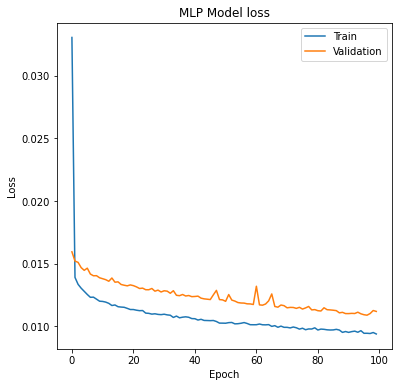

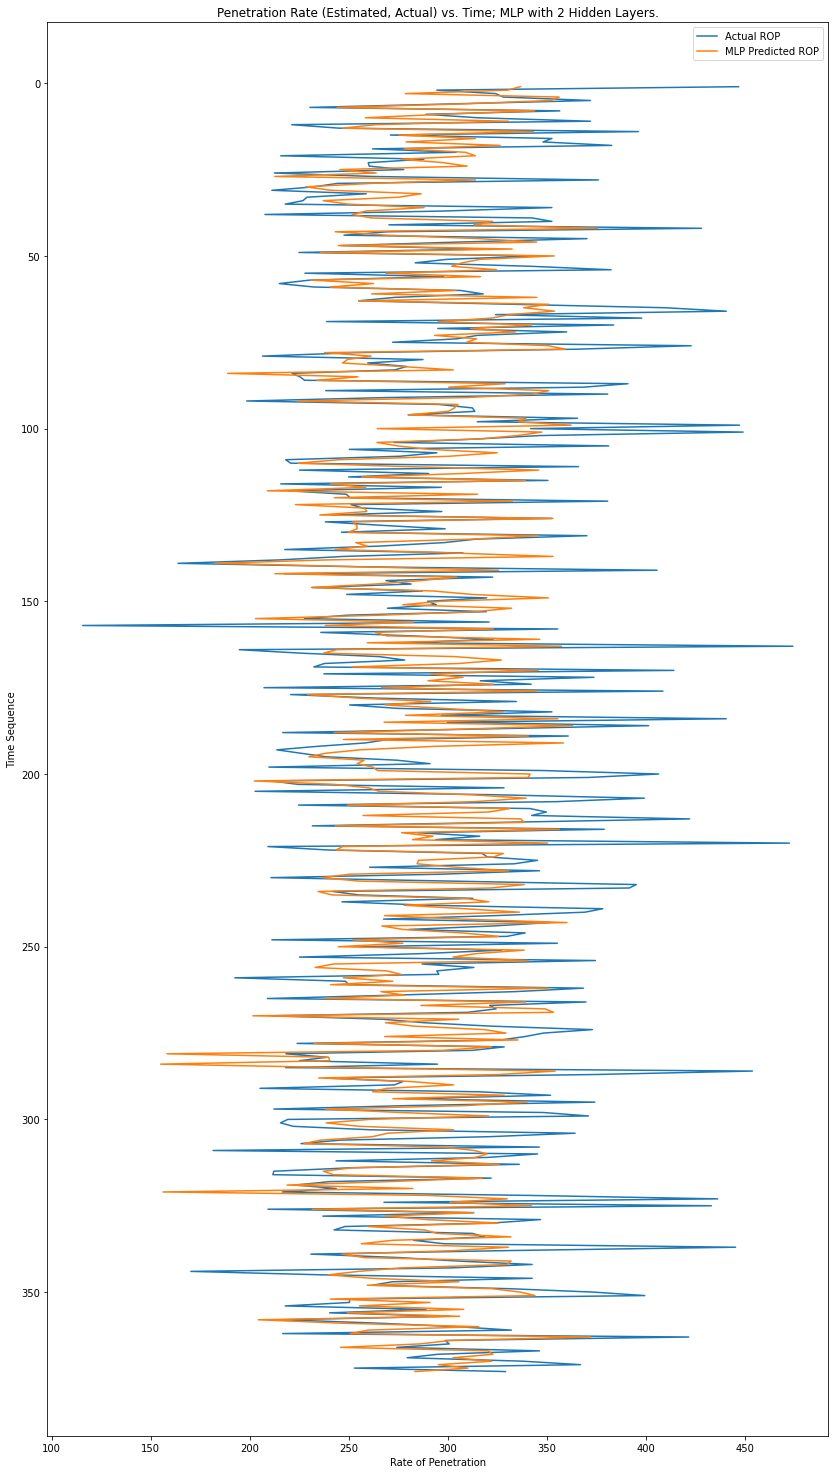

In [19]:
#Plot the loss reduction history over training epochs. 
plt.figure(figsize=(6,6))
plt.plot(MLP_model_combined_history.history['loss'])
plt.plot(MLP_model_combined_history.history['val_loss'])
plt.title('MLP Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

time_estimate_ROP = range(1, len(test_set_with_estimates) + 1)
plt.figure(figsize=(14,26))
plt.gca().invert_yaxis()
plt.plot("ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.plot("Estimated ROP", time_estimate_ROP, data=test_set_with_estimates)
plt.legend(['Actual ROP', 'MLP Predicted ROP'])
plt.title('Penetration Rate (Estimated, Actual) vs. Time; MLP with 2 Hidden Layers.')
plt.xlabel('Rate of Penetration')
plt.ylabel('Time Sequence')
plt.show()